In [1]:

from read_avi import *
os.chdir('/Users/davy/PycharmProjects/utd-mhad')
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import numpy as np

In [2]:

# Function to split the data into training and testing sets
def split_data(video_data, labels):
    X_train, X_test, y_train, y_test = train_test_split(video_data, labels, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


# Function to prepare data for machine learning training
def prepare_data_for_ml(directory, filesuffix):
    video_data, labels = process_avi_files(directory, filesuffix, None)
    # for video_num in range(0, len(video_data)):
    #     video_processor.save_video(video_data[video_num], output_file="out/vid/"+labels[video_num], frame_rate=video_processor.min_frame_count)
    X_train, X_test, y_train, y_test = split_data(video_data, labels)
    return video_data, labels

# Prepare data for ML training
video_data, labels = prepare_data_for_ml(avi_files_directory, avi_files_suffix)


Total frames/RGBMPG:  33


In [3]:

video_data.shape

(216, 33, 224, 224, 3)

## Feature Extraction

In [4]:

# Load a pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)


2024-01-25 20:21:42.619456: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-25 20:21:42.619479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-25 20:21:42.619485: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-25 20:21:42.619513: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-25 20:21:42.619526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Function to extract features using a pre-trained CNN (ResNet50 in this case)
def extract_features(video_data):
    # Load a pre-trained ResNet50 model
    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')

    num_videos = video_data.shape[0]
    features = []

    for i in range(num_videos):
        # Convert grayscale frames to 'RGB' by replicating the channel
        rgb_frames = np.repeat(video_data[i][..., np.newaxis], 3, axis=-1)

        # Extract features for each frame in a video
        video_features = model.predict(rgb_frames)
        # Average the features across all frames in a video
        avg_features = np.mean(video_features, axis=0)
        features.append(avg_features)

    return np.array(features)

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape, name='lstm_1'))
    model.add(Dropout(0.5))
    model.add(LSTM(100, name='lstm_2'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model






In [9]:
def visualize_features(features, labels):
    # Adjusting perplexity based on the number of samples
    perplexity = min(30, len(features) - 1)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_features = tsne.fit_transform(features)

    unique_labels = np.unique(labels)
    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    plt.figure(figsize=(10, 10))
    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], color=colors[i], label=label)
    plt.legend()
    plt.show()

2/2 [==============================] - 0s 119ms/step
Epoch 1/30
6/6 [==============================] - 2s 109ms/step - loss: 3.1638 - accuracy: 0.0291 - val_loss: 3.3211 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - 0s 21ms/step - loss: 3.1393 - accuracy: 0.0407 - val_loss: 3.3344 - val_accuracy: 0.0000e+00
Epoch 3/30
6/6 [==============================] - 0s 28ms/step - loss: 3.1489 - accuracy: 0.0523 - val_loss: 3.3408 - val_accuracy: 0.0000e+00
Epoch 4/30
6/6 [==============================] - 0s 23ms/step - loss: 3.1282 - accuracy: 0.0581 - val_loss: 3.3451 - val_accuracy: 0.0000e+00
Epoch 5/30
6/6 [==============================] - 0s 20ms/step - loss: 3.1378 - accuracy: 0.0407 - val_loss: 3.3480 - val_accuracy: 0.0227
Epoch 6/30
6/6 [==============================] - 0s 22ms/step - loss: 3.1232 - accuracy: 0.0872 - val_loss: 3.3496 - val_accuracy: 0.0227
Epoch 7/30
6/6 [==============================] - 0s 20ms/step - loss: 3.1303 - accuracy: 0.0640

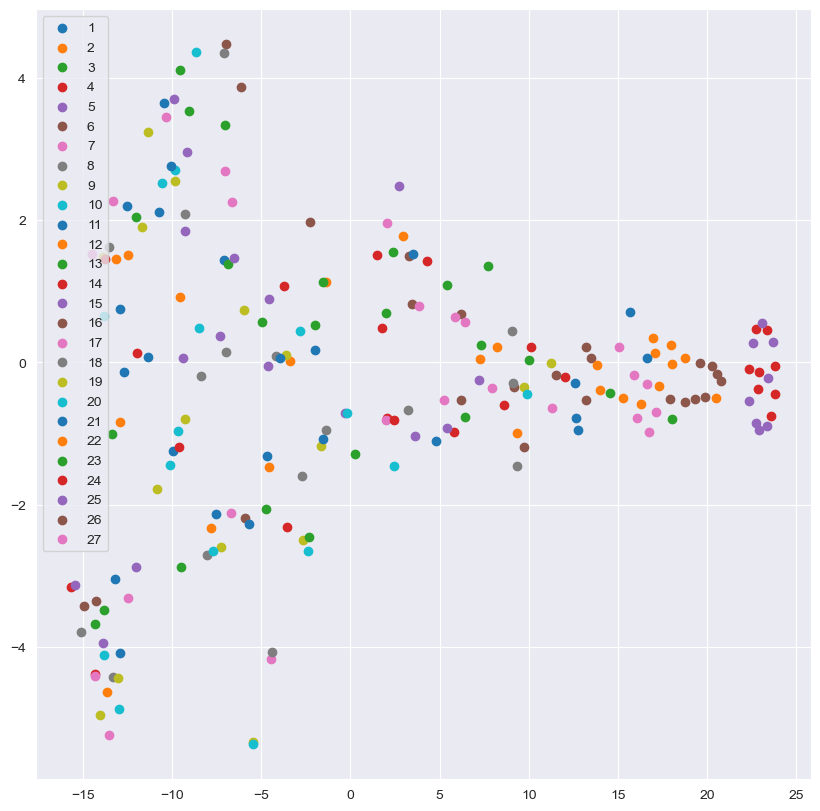

In [7]:

resnet_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')
features = extract_features(video_data, resnet_model)

# Preprocess features for LSTM
lstm_input = np.expand_dims(features, axis=1)  # Add time step dimension

input_shape = (lstm_input.shape[1], lstm_input.shape[2])
num_classes = 27  # 27 possible actions
lstm_model = build_lstm_model(input_shape, num_classes)

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(lstm_input, labels, epochs=30, batch_size=32, validation_split=0.2)

# Example usage
intermediate_model = tf.keras.Model(inputs=lstm_model.input, outputs=lstm_model.get_layer('lstm_2').output)
lstm_features = intermediate_model.predict(lstm_input)
visualize_features(lstm_features, labels)

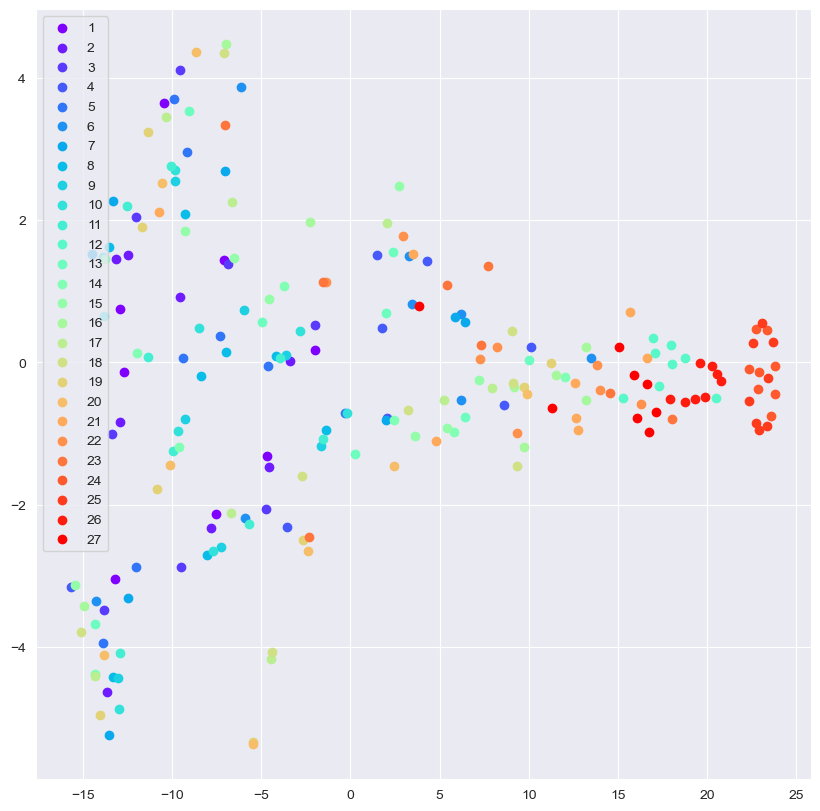

In [12]:
visualize_features(lstm_features, labels)


In [ ]:

# Convert labels to categorical
num_classes = 27
Y_train = to_categorical(y_train - 1, num_classes)
Y_test = to_categorical(y_test - 1, num_classes)

# Normalize the video data
X_train = X_train / 255.0
X_test = X_test / 255.0



In [ ]:
input_shape = X_train.shape[1:]
input_shape

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(27, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1)

In [ ]:
1# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])